# 🧱 [DACON - AutoEncoder](https://dacon.io/codeshare/4551)

---

In [1]:
# 라이브러리 불러오기
import warnings
warnings.filterwarnings(action = "ignore")

import torch
import torchvision
import torch.nn.functional as F

from torch import nn, optim
from torchvision import transforms, datasets

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

print("PyTorch Version :", torch.__version__)

PyTorch Version : 1.10.2


## 1. Hyperparameters

---

In [2]:
# Prepare Hyperparameters
EPOCH = 10
BATCH_SIZE = 64

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device :", DEVICE)

Using Device : cpu


In [3]:
torch.manual_seed(1)

## 2. Data Load

---

- Fashion MNIST 데이터에서 학습 데이터만을 이용한다.

- Fashion MNIST 데이터는 **Pytorch Tutorial** 폴더에 저장되어 있다.

In [4]:
# Fashion MNIST 학습 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root = "./PyTorch Tutorial/data/",
    train = True,
    download = False,
    transform = transforms.ToTensor()
)

print("Shape of Fashion MNIST :", trainset.data.shape, "\n")
print("Shape of first sample in Fashion MNIST :", trainset.data[0].shape, "\n")

# Data Loader 객체 생성
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

print("Shape of Data Loader of features :", list(train_loader)[0][0].shape, "\n")
print("Shape of Data Loader of target :", list(train_loader)[0][1].shape)

Shape of Fashion MNIST : torch.Size([60000, 28, 28]) 

Shape of first sample in Fashion MNIST : torch.Size([28, 28]) 

Shape of Data Loader of features : torch.Size([64, 1, 28, 28]) 

Shape of Data Loader of target : torch.Size([64])


- Fashion MNIST 데이터에 60,000개의 이미지가 존재하며, 한 개의 이미지는 28 x 28 로 구성되어 있다.

- 또한 위에서 배치 크기를 64로 지정해주었기 때문에 배치 크기가 64임을 확인할 수 있다.<br><br>

```python
trainset = datasets.FashionMNIST(
    root = "./PyTorch Tutorial/data/",
    train = True,
    download = False,
    transform = transforms.ToTensor())
```

- 위의 코드에서 `transform` 매개변수에 `torchvision.transforms.ToTensor()` 인자를 넣어주었다.

- 여기서 **`ToTensor()`** 함수는 [0, 255] 사이의 값을 가지는 PIL 이미지 혹은 Numpy 배열의 범위를 [0.0, 1.0] 범위를 가지는 텐서로 변경을 수행해준다.

- `trainset` 변수에 저장되어있는 데이터에는 해당 함수가 적용되지 않고, **`torch.utils.data.DataLoader()`** 함수를 적용한 값에 반영된다.

## 3. AutoEncoder Model

---

In [28]:
# AutoEncoder 클래스 정의
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # AutoEncoder 모델은 'Encoder', 'Decoder' 두 부분으로 구성해주어야 한다.
        # 'nn.Sequential'을 사용하여 두 부분을 구성해주도록 한다.
        
        # Encoder 정의
        self.encoder = nn.Sequential(
            
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
        
            nn.Linear(128, 64),
            nn.ReLU(),
        
            nn.Linear(64, 12),
            nn.ReLU(),
            
            # Input의 특징을 3차원으로 압축해주도록 한다.
            # 아래의 layer를 통해 나온 값이 'Latent Variable' 이다.
            nn.Linear(12, 3))
        
        # Decoder 정의
        self.decoder = nn.Sequential(
        
            # Decoder는 차원을 점점 28 * 28로 복원한다.
            nn.Linear(3, 12),
            nn.ReLU(),
        
            nn.Linear(12, 64),
            nn.ReLU(),
        
            nn.Linear(64, 128),
            nn.ReLU(),
        
            nn.Linear(128, 28 * 28),
            
            # 픽셀당 [0, 1] 사이로 값을 출력하도록 Sigmoid() 함수를 추가한다.
            nn.Sigmoid())
        
    def forward(self, x):
        
        # Encoder는 'encoded'라는 잠재변수를 만든다.
        encoded = self.encoder(x)
        
        # Decoder를 통해 복원이미지를 생성한다.
        decoded = self.decoder(encoded)
        
        return encoded, decoded

## 4. Optimizer & Loss

---

In [29]:
# 모델 객체 생성
autoencoder = AutoEncoder().to(DEVICE)

# Optimizer 생성
optimizer = optim.Adam(autoencoder.parameters(), lr = 0.005)

# 비용 함수 생성
criterion = nn.MSELoss()

- AutoEncoder 모델을 통해서 원본 이미지가 어떻게 복원되는지 확인해보도록 한다.

In [7]:
# 원본 이미지를 시각화 하기 위해 데이터 저장
view_data = trainset.data[:5].view(-1, 28 * 28) # torch.Size([5, 28, 28]) → torch.Size([5, 784])

# 픽셀의 색상값이 [0, 255] 이므로 [0, 1] 사이의 값으로 변경해준다.
view_data = view_data.type(torch.FloatTensor) / 255.

## 5. Model Train

---

In [8]:
# 학습을 진행하기 위한 함수 생성
def train(autoencoder, train_loader):
    
    # 모델을 학습 모드로 전환
    autoencoder.train()
    
    for index, (X, Y) in enumerate(train_loader):
        
        # 모델을 통해 학습을 진행하기 위해서는 Flatten을 진행해주어야 한다.
        # 또한, X, Y 모두 원본이미지인 것을 주의하도록 한다.
        X = X.view(-1, 28 * 28).to(DEVICE)
        Y = X.view(-1, 28 * 28).to(DEVICE)
        
        label = Y.to(DEVICE)
        
        # 모델을 통한 예측 진행
        encoded, decoded = autoencoder(X)
        
        # 손실값 계산
        loss = criterion(decoded, Y)
        
        # 기울기에 대한 정보 초기화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1/10]


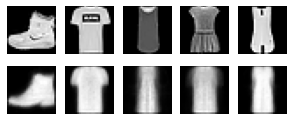

[Epoch 2/10]


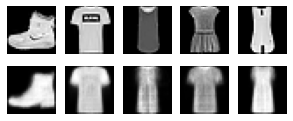

[Epoch 3/10]


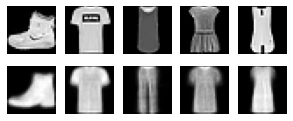

[Epoch 4/10]


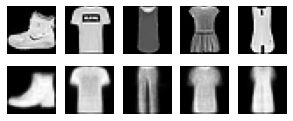

[Epoch 5/10]


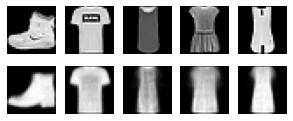

[Epoch 6/10]


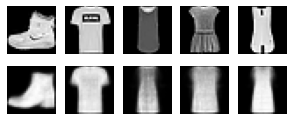

[Epoch 7/10]


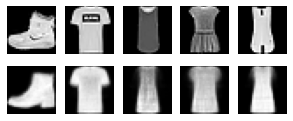

[Epoch 8/10]


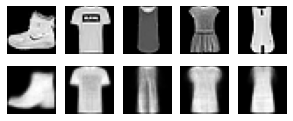

[Epoch 9/10]


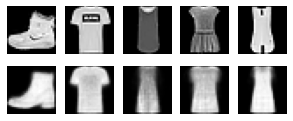

[Epoch 10/10]


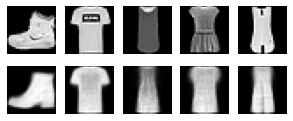

In [9]:
# Epoch 수만큼 학습 진행
for epochs in range(1, EPOCH + 1):
    
    # 정의한 모델을 사용하여 학습 진행
    train(autoencoder, train_loader)
    
    # Decoder를 통해 복구된 이미지 시각화하기
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    # 원본이미지와 비교하기
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (5, 2))
    
    print("[Epoch {}/{}]".format(epochs, EPOCH))
    
    # 원본 이미지 시각화
    for index in range(5):
        
        # 이미지를 시각화하기 위해서 배열을 변경해주도록 한다.
        # torch.Szie([784]) → (28, 28)
        img = np.reshape(view_data.data.numpy()[index], (28, 28))
        
        axes[0][index].imshow(img, cmap = "gray")
        axes[0][index].set_axis_off()
        
    # AutoEncoder를 통해 복구된 이미지 시각화
    for index in range(5):
        
        img = np.reshape(decoded_data.to("cpu").data.numpy()[index], (28, 28))
        
        axes[1][index].imshow(img, cmap = "gray")
        axes[1][index].set_axis_off()
        
    plt.show()

- Epoch이 반복될수록 복구된 이미지가 점점 선명해짐을 확인할 수 있다.

## 6. Latent Variable Check

---

- 원본 데이터 200개를 학습하고, 학습을 진행하는 과정에서 **Latent Variable**을 확인해보도록 하자.

In [10]:
# 원본 이미지 200개 준비
view_data = trainset.data[:200].view(-1, 28 * 28) # torch.Size([200, 28, 28]) → torch.Size([200, 784])
view_data = view_data.type(torch.FloatTensor) / 255.

test_x = view_data.to(DEVICE)
print("Shape of View Data :", test_x.size())

Shape of View Data : torch.Size([200, 784])


In [13]:
# Gradient 계산을 수행하지 않으면서 진행
with torch.no_grad():
    
    # 학습 진행
    encoded_data, _ = autoencoder(test_x)
    encoded_data = encoded_data.to("cpu")

print("Shape of Encoded Data :", encoded_data.size())

Shape of Encoded Data : torch.Size([200, 3])


- 현재 모델 Encoder 부분의 Bottleneck layer 출력이 `nn.Linear(12, 3)`으로 3이기 때문에 위의 결과가 나왔다.

- 시각화를 통해 같은 레이블끼리 모여있는지 확인해보도록 한다.

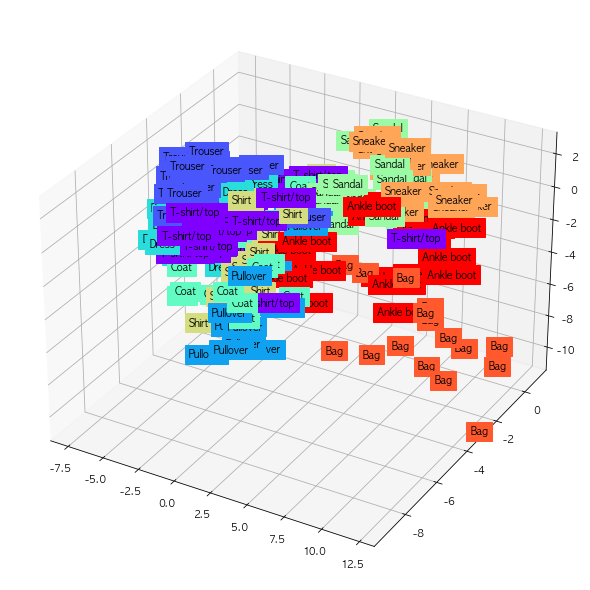

In [14]:
# 레이블 값 정의
CLASSES = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}

fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)

# Latent Variable의 각 차원을 Numpy 행렬로 변환해주도록 한다.
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

# 200개 데이터의 레이블도 Numpy 행렬로 변환한다.
labels_numpy = trainset.targets[:200].numpy()

for x, y, z, label in zip(X, Y, Z, labels_numpy):
    name = CLASSES[label]
    color = cm.rainbow(int(255 * label / 9))
    
    ax.text(x, y, z, name, backgroundcolor = color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

- 같은 레이블을 가진 이미지의 잠재변수는 서로 모여있음을 확인할 수 있다.

- 또한 티셔츠, 드레스, 코트, 셔츠와 같은 윗옷들끼리의 거리는 가깝거나 겹치고, 신발류인 앵클부츠, 샌들 운동화도 서로 가까이 자리하는 것을 볼 수 있다.

# <span style="color:brown">🌠 AutoEncoder로 망가진 이미지 복원하기</span>

---

- 잡음제거 오토인코더(Denoising Autoencoder)는 2008년 몬트리올 대학에서 발표한 논문 <a href="https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf">`Extracting and Composing Robust Features with Denosing AutoEncoder`</a> 에서 처음 제안되었다.

- AutoEncoder가 Encoder 부분을 통해 '압축'이 일어나는데, **압축**이 데이터의 특성에 중요도로 우선순위를 매기고 낮은 우선순위의 데이터를 버린다는 뜻이기도 하다.

- **잡음제거 AutoEncoder**의 아이디어는 중요한 특징을 추출하는 AutoEncoder의 특성을 이용하여 비교적 `덜 중요한 데이터`인 잡음을 버려 원래의 데이터를 복원한다는 것이다.

- 지금가지 진행했던 모델과 큰 차이가 없으며, 학습을 진행할 때 입력에 잡음을 더하는 방식으로 복원 능력을 강화한 것이 핵심이다.

In [25]:
# 이미지에 노이즈를 더해주는 함수 생성
def add_noise(img):
    
    # 'torch.randn()' 함수를 사용해서 입력된 이미지와 같은 크기의 잡음을 생성
    # 잡음의 강도는 임의로 0.2
    noise = torch.randn(img.size()) * 0.2
    
    noisy_img = img + noise
    
    return noisy_img

- `torch.randn()` 함수는 표준정규분포에서 랜덤하게 값을 추출해주는 함수이다.

## 1. Model Train

---

- AutoEncoder architecture는 위에서 정의한 `AutoEncoder` 클래스를 사용한다.

- 해당 과정을 진행하기 전에 모델이 이미 학습이 진행된 상태이므로 다시 불러오도록 한다.

In [31]:
# 학습을 진행하는 코드에 잡음을 추가하는 코드 추가
def train(autoencoder, train_loader):
    
    # 모델을 학습 모드로 전환
    autoencoder.train()
    
    # 손실값을 출력하기 위한 초기값 설정
    avg_loss = 0
    
    for index, (X, label) in enumerate(train_loader):
        
        # 입력값에 잡음을 추가
        noisy_x = add_noise(X)
        noisy_x = noisy_x.view(-1, 28 * 28).to(DEVICE)
        
        Y = X.view(-1, 28 * 28).to(DEVICE)
        
        label = label.to(DEVICE)
        
        # 생성한 모델을 통해 학습 진행
        encoded, decoded = autoencoder(noisy_x)
        
        # 손실값 계산
        loss = criterion(decoded, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        
    return avg_loss / len(train_loader)

In [32]:
# Epoch 수만큼 학습 진행
for epoch in range(1, EPOCH + 1):
    
    loss = train(autoencoder, train_loader)
    print("Epoch {}/{} Loss : {}\n".format(epoch, EPOCH, loss))

Epoch 1/10 Loss : 0.03926445994732667

Epoch 2/10 Loss : 0.0282885830507858

Epoch 3/10 Loss : 0.02514117224010895

Epoch 4/10 Loss : 0.024279105641853326

Epoch 5/10 Loss : 0.02380422527578149

Epoch 6/10 Loss : 0.023435034727586356

Epoch 7/10 Loss : 0.023162855641610587

Epoch 8/10 Loss : 0.023002001756766456

Epoch 9/10 Loss : 0.022984590369469322

Epoch 10/10 Loss : 0.022793537937104702



## 2. Visualization

---

In [36]:
# 모델이 학습시 한 번도 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져온다.
testset = datasets.FashionMNIST(
    root = "./PyTorch Tutorial/data/",
    train = False,
    download = False,
    transform = transforms.ToTensor()
)

print("Shape of Fashion MNIST Test :", testset.data.shape, "\n")
print("Shape of first sample in Fashion MNIST Test :", testset.data[0].shape)

Shape of Fashion MNIST Test : torch.Size([10000, 28, 28]) 

Shape of first sample in Fashion MNIST Test : torch.Size([28, 28])


In [46]:
# 테스트 데이터에서 이미지 한 장을 추출
sample_data = testset.data[0].view(-1, 28 * 28) # torch.Size([28, 28]) → torch.Size([1, 784])
sample_data = sample_data.type(torch.FloatTensor) / 255.

# Gradient 계산을 수행하지 않으면서 진행
with torch.no_grad():
    
    # 모델을 평가 모드로 전환
    autoencoder.eval()
    
    original_x = sample_data[0]
    
    # 추출한 이미지에 잡음 추가
    noisy_x = add_noise(original_x).to(DEVICE)
    
    # 학습된 모델을 통해 복구된 이미지 추출
    _, recovered_x = autoencoder(noisy_x)

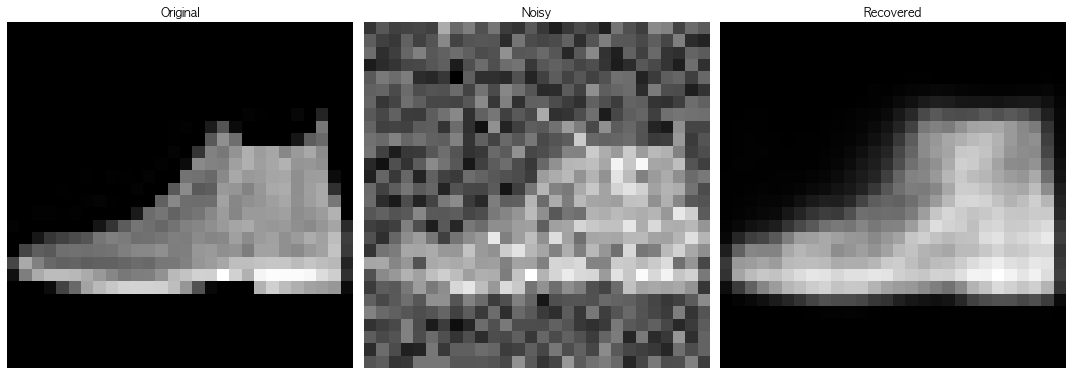

In [57]:
# 시각화 수행
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))

# 시각화를 위해 넘파이 행렬로 바꿔주도록 한다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
axes[0].set_title("Original")
axes[0].set_axis_off()
axes[0].imshow(original_img, cmap = "gray")

# 잡음 사진
axes[1].set_title("Noisy")
axes[1].set_axis_off()
axes[1].imshow(noisy_img, cmap = "gray")

# 복원된 사진
axes[2].set_title("Recovered")
axes[2].set_axis_off()
axes[2].imshow(recovered_img, cmap = "gray")

fig.tight_layout()